### **Logistic Regression From Scratch**

**Introduction**

Logistic Regression is typically utulized when your outcome/dependent variable is in the form of binary. Example, this could be recording data on whether the patient had diabetes (y = 1) or not (y = 0), or even simple as, "is this a cat (y = 1) or not (y = 0)". It is used often times for classification tasks such as the example of, "is this a cat or not"?

As an input for its indepdent variable, it is capable of handling continous and discrete variables. 

The model is expressed as

### $\hat{p} = \frac{1}{1 + e^{-(\beta_0 + \beta_{1}x_1 + \beta_{2}x_2 .... \beta_{p}x_p)}}$

This is essentially using the logit function to constrain our values from $(-k,k)$ to $(0,1)$

In addition, often times when we conduct a logistic regression, we want not just the probability of the outcome of $x_1, x_2, .... x_p$. In this case, we would get the **log odds**, which will be:

#### $ln(\frac{\hat{p}}{1 - \hat{p}}) = \beta_0 + \beta_{1}x_1 + \beta_{2}x_2 .... \beta_{p}x_p$


**Assumptions**

1. Logistic regression requires the dependent variable to be binary and ordinal.

2. The data must be indepedent.

3. There should be no multicolinearity among the indepdent variables.

4. Logistic regression requires that the independent variables are linearly related to the log odds of the dependent variable.

5. An adequete sample size.

**Goal**

The Goal of this excerise is to implement the model from scratch without using `glm()` function.

**Motivation**

As for the motivation, these kind of excerises are good for any data science interview preperation as you are able to get the fundementals down. Understand the coeffecients, theory, and math/statistics behind LR.

#### **R Code Implementation**

import data, ggplot2 (data visualization), and dplyr (data manipulation library).

In [28]:
options(warn = -1)

library(readr)
library(dplyr)
library(ggplot2)

dog.bites = read_csv("/kaggle/input/predict-new-york-dog-bites/Dog_Bites_Data.csv")

Rows: 22663 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): DateOfBite, Species, Breed, Age, Gender, Borough, ZipCode
dbl (1): UniqueID
lgl (1): SpayNeuter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Now, we will be selecting the variables that I will be using to create my model, which are `Breed`, `Borough` , and `SpayNeuter`. 

* `Breed`: The breed of the dog
* `Borough`: The governmental districts that compose NYC
* `SpayNeuter`: Whether the dog has been neutered or not

In [29]:
dog.bites = dog.bites %>% select(c(Breed,Borough,SpayNeuter))

#### **Understanding: `Breed`**

In [30]:
# lower case all breeds 
dog.bites$Breed = tolower(dog.bites$Breed)

In [31]:
#  Filter out missing dog breed entries and breeds that weren't classified
dog.bites = dog.bites %>% filter(!is.na(Breed) & Breed != "unknown") 

Now, the problem is that we have too many features. For example, each breed we have, we would need to one hot encode them on top of the variable `Borough`. As we explained, Logisitic regression is a classification model, but in essence, it works the best when the model is simple. Kind of suscribing to the idea of rule of parsimony. We want to prevent the curse of dimensionality, where too many features can actually be bad as it we would lead to multicoliearnity and overfitting.

Now, what I normally would consider to go about this are the following: PCA, stepwise forward regression, different ML algorithim, or even regularization techniques.

In [32]:
# There are too many dog breeds, so we would choose breeds that are top 5
dog.bites$Breed = ifelse(grepl("pit[ ]?bull", dog.bites$Breed) == TRUE, "pit bull",dog.bites$Breed)
dog.bites$Breed = ifelse(grepl("shih[ ]?tzu", dog.bites$Breed) == TRUE, "shih tzu",dog.bites$Breed)
dog.bites$Breed = ifelse(grepl("chihuahua", dog.bites$Breed) == TRUE, "chihuahua",dog.bites$Breed)
dog.bites$Breed = ifelse(grepl("mixed", dog.bites$Breed) == TRUE, "mixed/other",dog.bites$Breed)

In [33]:
result = dog.bites %>% group_by(Breed) %>% summarise(percent_bites = (n() / nrow(dog.bites))* 100)  %>% arrange(desc(percent_bites)) %>% slice(1:5)
result

Breed,percent_bites
<chr>,<dbl>
pit bull,30.137592
mixed/other,8.658894
shih tzu,5.266066
chihuahua,4.741117
german shepherd,3.448085


In [34]:
dog.bites = dog.bites %>% filter(Breed %in% result$Breed)

#### **Understanding: `Borough`**

In [35]:
unique(dog.bites$Borough)

[1] "Brooklyn"      "Bronx"         "Manhattan"     "Other"        
[5] "Queens"        "Staten Island"

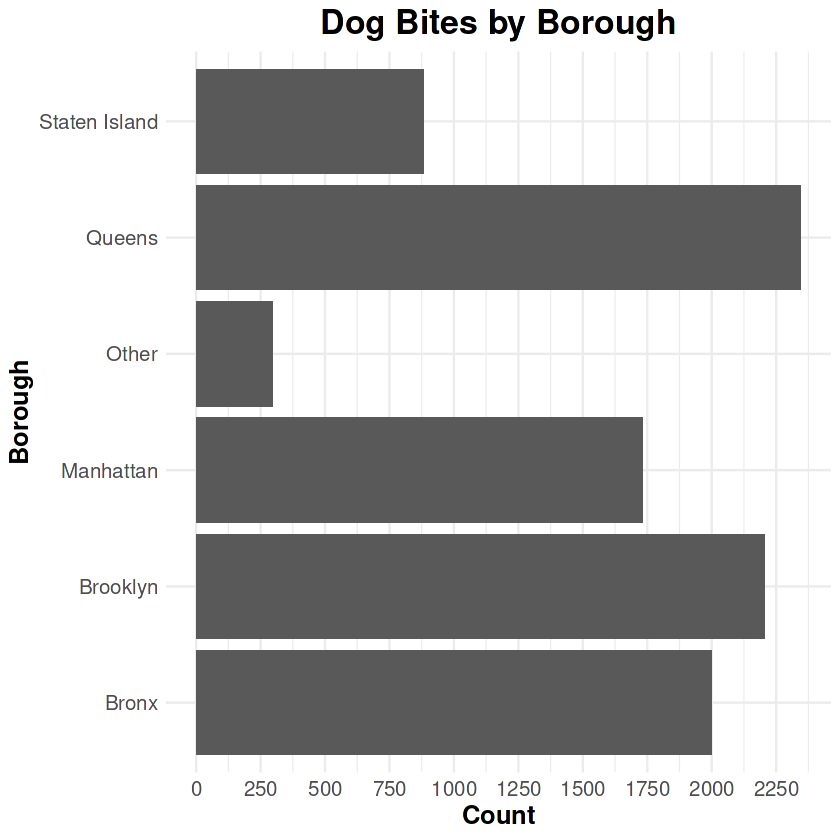

In [36]:
ggplot(dog.bites,aes(x = Borough)) + geom_bar() + coord_flip() + ylab("Count") + 
ggtitle("Dog Bites by Borough") + scale_y_continuous(breaks = seq(0, 2500, 250)) + 
theme_minimal() + theme(axis.text = element_text(size = 12), 
                        axis.title = element_text(size = 15, face = "bold"),
                        plot.title = element_text(size = 20,hjust = 0.5, 
                                                  face = "bold"))

Clearly, most dog bites occur in Queens. Brooklyn is close second. 

#### **Understanding: `SpayNeuter`**

In [37]:
# one hot encode spayneuter as our outcome variable
dog.bites$SpayNeuter_ohe = ifelse(dog.bites$SpayNeuter == TRUE, 1, 0) 

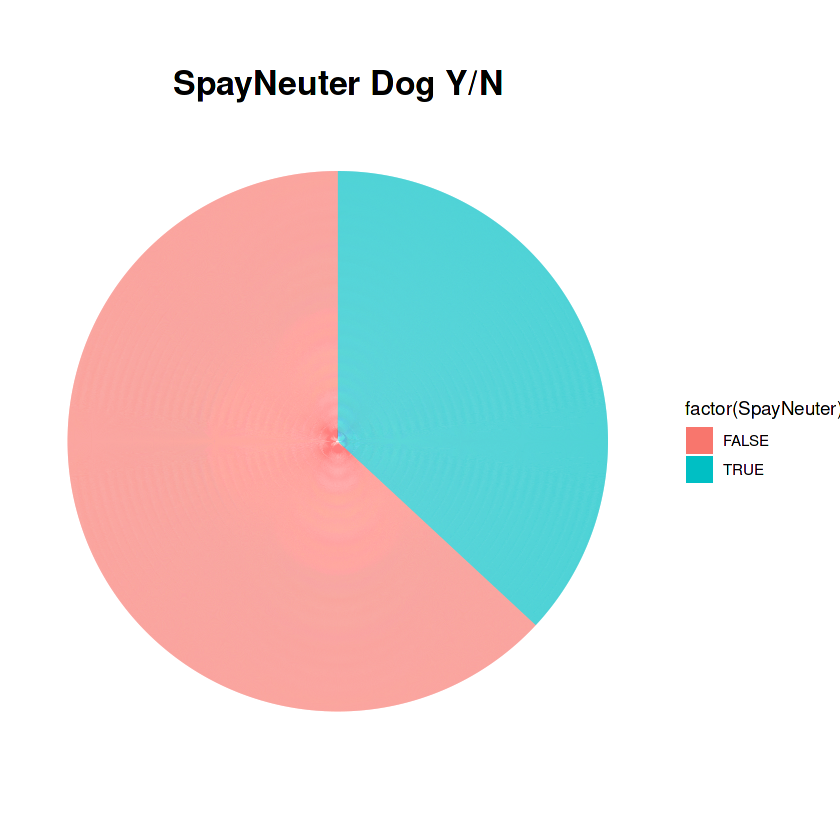

In [38]:
ggplot(dog.bites, aes(x="", y=factor(SpayNeuter), fill=factor(SpayNeuter))) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) + theme_void() + ggtitle("SpayNeuter Dog Y/N") +
  theme(plot.title = element_text(hjust = 0.5, size = 20, face = "bold"))

We can see that most of the dog bites come from dogs that are not neutered. Just throwing things out there, but I assume there would be high correlation between dog being neutered to the dog having an owner. 

#### **Understanding: `Breed`, `SpayNeuter`, AND `Borough`**

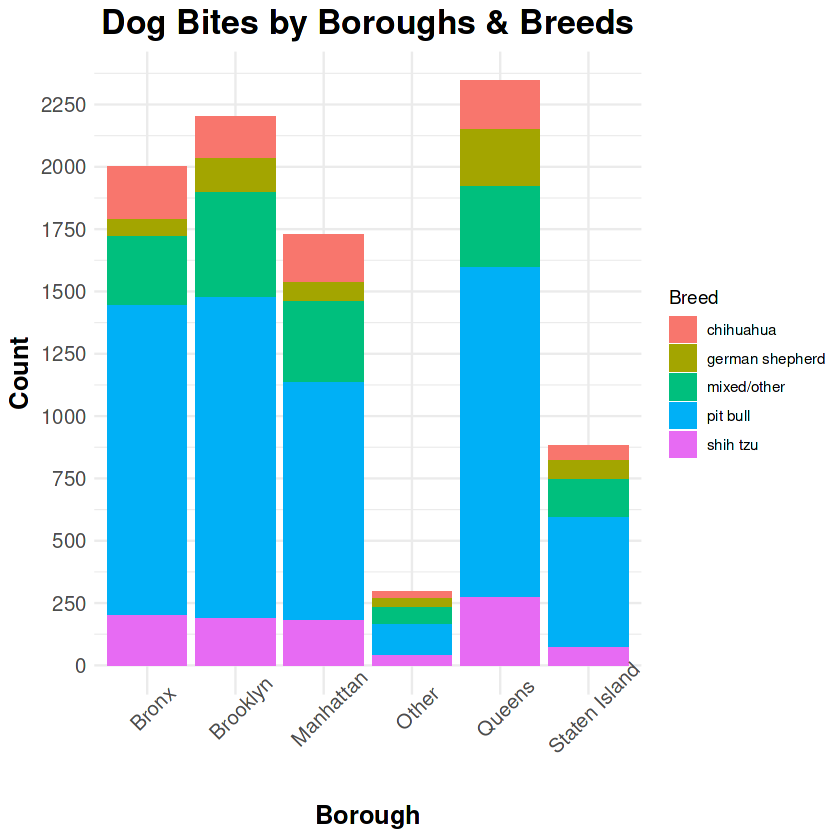

In [39]:
ggplot(dog.bites,aes(x = Borough, fill = Breed)) + geom_bar() + ylab("Count") + 
ggtitle("Dog Bites by Boroughs & Breeds") + scale_y_continuous(breaks = seq(0, 2500, 250)) + 
theme_minimal() + theme(axis.text = element_text(size = 12), 
                        axis.text.x = element_text(angle = 45),
                        axis.title = element_text(size = 15, face = "bold"),
                        plot.title = element_text(size = 20,hjust = 0.5, 
                                                  face = "bold"))

Ofcourse, there are many variables that come into play when visualizing these kind of data, but we can see that most dog bites across all boroughs that pit bulls occurs the most. Again, this could be because there are more pitbull dog owners in NYC. Hence, if people were curious to do analysis on this,they could calculate per capita instead of raw dog bite counts.

In [40]:
dog.bites %>% group_by(Borough) %>% filter(Breed == "pit bull") %>% summarise(count = n()) %>% arrange(desc(count))

Borough,count
<chr>,<int>
Queens,1324
Brooklyn,1287
Bronx,1245
Manhattan,953
Staten Island,521
Other,124


### **Model Building: Logistic Regression**

Split data based on train (70%) and test (30%).

In [41]:
# sample 70% of nrow(dog.bites), and sort them
sp = sort(sample(nrow(dog.bites), nrow(dog.bites)*.7)) 

In [42]:
train = dog.bites[sp,] 
test = dog.bites[-sp,]

#### 1. Using: **glm(y ~ x, data, family = binomial)**

In [43]:
model = glm(SpayNeuter_ohe ~ Borough + Breed, data = train, family = binomial(link = "logit"))
summary(model)


Call:
glm(formula = SpayNeuter_ohe ~ Borough + Breed, family = binomial(link = "logit"), 
    data = train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.45867    0.11475 -12.712  < 2e-16 ***
BoroughBrooklyn       0.82315    0.10461   7.869 3.59e-15 ***
BoroughManhattan      1.02391    0.10736   9.537  < 2e-16 ***
BoroughOther          1.26500    0.17385   7.277 3.42e-13 ***
BoroughQueens         1.06822    0.10137  10.538  < 2e-16 ***
BoroughStaten Island  1.10751    0.12428   8.911  < 2e-16 ***
Breedgerman shepherd -0.42327    0.13974  -3.029  0.00245 ** 
Breedmixed/other     -1.01438    0.11876  -8.541  < 2e-16 ***
Breedpit bull        -0.73211    0.09587  -7.636 2.24e-14 ***
Breedshih tzu         0.05672    0.11932   0.475  0.63453    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7147.7  on 6618  degrees of freedom
Residual devi

#### **2. Maximum Likelihood Estimation: Parameter Estimation**

Maximum likelihood is an estimation of parameter values that maximizes the likelihood of the observed data.

Recall the logistic regression equation:

### $\hat{p} = \frac{1}{1 + e^{-(\beta_0 + \beta_{1}x_1 + \beta_{2}x_2 .... \beta_{p}x_p)}}$

Let's estimate the logistic regression parameters of $\beta$

In [44]:
sigmoid = function(z){
    return (1 / (1 + exp(-z)))
}

**Likelihood Function & Log Likelihood**

In order to do this, we would need to maximize the following function called **Likelihood Function**

#### $L(\beta) = \prod_{s} p(x_i)^{y_i} * (1 - p(x_i))^{1 - y_i}$

where $x_i$ is the feature at ith sample, and $y_i$ is the outcome at ith sample

And if we apply *log* to our likelihood function, we will get the **log likelihood**, which is

#### $l(\beta) = \sum {y_i log(p(x_i)) + (1 - y_i)log(1 - p(x_i))} $

This will be the function which we need to maximize

In [45]:
log_likelihood = function(X,y,beta){
    p_hat = sigmoid(X %*% beta) # p^ = X (r x c) %*% beta (vector of betas)
    return(sum(y * log(p_hat) + (1 - y) * log(1 - p_hat))) #log likelihood formula
}

**Maximizing Log Likelihood Function**

Since the goal is to maximize the log likelihood function, we will be using **Newton-raphson method** to accomplish this. This iterative method helps you find the best value $\beta$ by approximating the root of the log likelihood function, which leads to to finding the local maxima. 

**Newton-raphson method**: $x_1 = x_0 - \frac{f(x_0)}{f'(x_0)}$

* $x_0 =$ initial value of $x_0$
* $f(x_0) =$ value of the equation at $x_0$
* $f'(x_0) =$ value of the first order derivative of the equation at $x_0$

In [46]:
log_ll_gradient = function(X,Y,beta){
    p_hat = sigmoid(X %*% beta)
    gradient = t(X) %*% (Y - p_hat) # gradinet = X transpose %*% (Y - p^)
    return (gradient)
} # The derivative calculation can be found the medium article referenced below

Hessian matrix is a square matrix of second-order partial derivatives of a scalar-valued function.

Weighted matrix is a diagonal matrix, where each diagonal element is the variance of the predicted probability for the corresponding observation. 

In [47]:
heissen_matrix = function(X,Y,beta){
    p_hat = sigmoid(X %*% beta)
    W = diag(as.vector(p_hat * (1 - p_hat))) # W = Diagnol matrix with p_hat
    return(- t(X) %*% W %*% X) # Matrix form of all second-order derivatives
}

Remember, dividing is different in matrix. Hence, when calculating for the new beta, we would need multiply the first order derviate with the inverse of the heissen matrix.

In [48]:
newton_raphson = function(X,Y,beta_init,tol = 1e-5,iter){
    beta = beta_init # since it is iterative method, initiate beta
    
    for(i in 1:iter){ # each iteration, calculate gradient, heissen matrix, and get new beta
        grad = log_ll_gradient(X,Y,beta)
        H = heissen_matrix(X,Y,beta)
        
        new_beta = beta - solve(H) %*% grad # solve(H) = H^-1 
        
        if(max(abs(new_beta)) < tol){ # if the maximum change between old beta to new beta is insignificant, break loop
            break
        }
        
        beta = new_beta # assign calculated beta as new beta
    }
    
    return(beta)
}

Now, we compare the results from the **glm** function to our logistic regression model we built from scratch using maximum likelhood estimation.

In [49]:
lapply(train[,-c(1,3)],unique)

#Breedgerman shepherd -0.44531    0.11808  -3.771 0.000162 ***
#Breedmixed/other     -0.97691    0.10079  -9.693  < 2e-16 ***
#Breedpit bull        -0.71123    0.08141  -8.736  < 2e-16 ***
#Breedshih tzu 

#BoroughBrooklyn       0.73753    0.08647   8.529  < 2e-16 ***
#BoroughManhattan      0.94842    0.08830  10.741  < 2e-16 ***
#BoroughOther          1.21809    0.14489   8.407  < 2e-16 ***
#BoroughQueens         0.98154    0.08353  11.751  < 2e-16 ***
#BoroughStaten Island  

$Borough
[1] "Brooklyn"      "Bronx"         "Manhattan"     "Other"        
[5] "Queens"        "Staten Island"

$SpayNeuter_ohe
[1] 0 1

Set up our X matrix and Y vector:

In [50]:
# One hot encode our variables and turn it into matrix data, so we can get our model

# Breed
X_pit_bull = ifelse(train$Breed == "pit bull",1,0)
X_mixed = ifelse(train$Breed == "mixed/other",1,0)
X_german = ifelse(train$Breed == "german shepherd",1,0)
X_shih = ifelse(train$Breed == "shih tzu",1,0)

# Borough
X_brooklyn = ifelse(train$Borough == "Brooklyn",1,0)
X_manhattan = ifelse(train$Borough == "Manhattan",1,0)
X_other = ifelse(train$Borough == "Other",1,0)
X_queens = ifelse(train$Borough == "Queens",1,0)
X_staten = ifelse(train$Borough == "Staten Island",1,0)

# Neuter outcome variable vector
Y = train$SpayNeuter_ohe
# Combine our X data including our intercept column
X = cbind(1,X_pit_bull,X_mixed,X_german,X_shih,X_brooklyn,X_manhattan,X_other,X_queens,X_staten)

In [51]:
# Initialize a matrix, technically column vector, with 1 column and ncol(X) rows and fill with 0.
beta_init = matrix(0, ncol(X), 1)

# Conduct Maximum Liklihood estimation using the Newton-Raphson method to estimate coefficients
beta_est = newton_raphson(X, Y, beta_init,iter = 50)

print(beta_init)
print(beta_est)

      [,1]
 [1,]    0
 [2,]    0
 [3,]    0
 [4,]    0
 [5,]    0
 [6,]    0
 [7,]    0
 [8,]    0
 [9,]    0
[10,]    0
                   [,1]
            -1.45866866
X_pit_bull  -0.73210948
X_mixed     -1.01437837
X_german    -0.42326748
X_shih       0.05671905
X_brooklyn   0.82314782
X_manhattan  1.02391109
X_other      1.26499506
X_queens     1.06821653
X_staten     1.10750614


#### **Results AND Accuracy:**

In [53]:
result = predict(model,newdata = test, type = "response") # use our new model, and predict using test data
result = ifelse(result > 0.5, 1,0) # if result is > 0.5, assign neutered (1) and not neutered(0)

In [54]:
misClasificError = mean(result != test$SpayNeuter_ohe) # calculate mean predicted that did not equal to actual Y
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.783574198096581"


In [ ]:
exp(-0.36791) # Odds Ratio German Shepherd
(0.692−1)×100=−0.308×100 # Percent Change

### **Interpretation**
  
Our model:

##### $ln(\frac{\hat{p}}{1 - \hat{p}}) = -1.45065 - 0.36791(German Shepherd) -1.02305 (Mixed /Other) -0.70949(Pit Bull) - 0.13213(Shih Tzu) + 0.79347(Brooklyn) + 0.97982(Manhattan) + 1.27791(other) + 0.97958(Staten Island)$

For an example, this fitted model says that, when holding Mixed/Other, Pitbull, Shih Tzu, Brooklyn, other (boroughs), Manhatten, and Staten Island at a fixed value, the odds of the event (bitten dog being neutered or not) for a German Shepherd are 30.8% lower than for the reference breed, and the odds of the event for a German Shepherd are 0.692 times the odds for the reference breed. 

### Additional Information

We can see that after using `glm` function to create our model and using the **maximum likelihood estimation** method, we get very similar results.

On top of that, we used that model to predict using dog `Breeds` and NYC `Borough` to see if the dog that bit people were neutered or not. 

The model we created achieved 78% accuracy, which is a decent result. This means the model was able to correctly predict the outcome (whether the dog that bit someone is neutered or not) in 78% of the cases, using the variables `Breeds` and `Borough`.



References:
- https://arunaddagatla.medium.com/maximum-likelihood-estimation-in-logistic-regression-f86ff1627b67
- https://rpubs.com/aaronsc32/newton-raphson-method